# Batch Bayesian Optimization for Composition

## 1. Library Reading

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C, DotProduct
import warnings
warnings.simplefilter('ignore')

## 2. Parameter setting

In [2]:
# Unit definition
title_data = 'Ru3(CO)12 [RuCl2(CO)3]2 HRh(CO)(PPh3)3 Rh(acac)(CO)2 RhCl(CO)(PPh3)2 [bmim][Cl] [bmim][BF4]'.strip().split()
title_out = 'EXP-No. EXP-ID Ru3(CO)12 [RuCl2(CO)3]2 HRh(CO)(PPh3)3 Rh(acac)(CO)2 RhCl(CO)(PPh3)2 [bmim][Cl] [bmim][BF4]'.strip().split()
unit_gmol = np.array([639.33, 512.01, 918.80, 258.03, 690.94, 174.67, 226.03]) # g/mol
unit2mmol = np.array([0.09/3, 0.09/2,   0.09,   0.09,   0.09,    3.0/1.08,   3.0/1.21]) *0.01  # 0.09 mmol/metal, 0.01 is correction for % unit
unit2mg   = unit2mmol*unit_gmol # mg/metal

# Number of experimental data per round
n_total = 24
n_reference = 2
n_round = n_total - n_reference
nbatch = int(n_round/2) # separating the n_round to Exploration and exploitation

# Reading Grid-data
grids = np.loadtxt('first_10.dat')

# Setting GPR parameter
alpha = 0 # because white kernel is used
aq_type = "EI" #
bbo_type = "kriging"
coeficient = 100 # controlling the degree of exploration

## 3. Experimental data Reading

In [3]:
experimental_id = ['Round-001']
date = 'Round1'
df_all = pd.read_csv("Results-DB_%s.csv"%(date), encoding="shift-jis")
df_all = df_all[df_all['PJ-ID'].isin(experimental_id)]

y_label = ['Ald_Yield']
x_label = [
    'Cat1.actual, mg', 'Cat2.actual, mg', 'Cat3.actual, mg',       
    'Cat4.actual, mg', 'Cat5.actual, mg', 'Ion1.actual, μL',
    'Ion2.actual, μL', 'CO2, MPa', 'H2, MPa'
]
x_data_all = df_all[x_label].to_numpy()
y_data_all = df_all[y_label].to_numpy()
a_data_all = df_all['EXP-ID']
ndata, ndim = x_data_all.shape if len(experimental_id)*24 == x_data_all.shape[0] else print('ERROR: amount of dataset')

# Transform the unit from mg to %
x_data_all[:,:-2] = x_data_all[:,:-2]/unit2mg
x_data_all[:,:-2] = x_data_all[:,:-2]*100/np.sum(x_data_all[:,:-2],axis=1).reshape((ndata,1))
x_data_all[:,-2:] = x_data_all[:,-2:]*10.0

y_data = y_data_all
x_data = x_data_all[:,:-2]
a_data = a_data_all

print("Ndata:", ndata,", Ndim:", ndim)

Ndata: 24 , Ndim: 9


## 4. Function setting

In [4]:
## SEARCH BETTER ARGMENTs TO AVOID SAMPLING SAME CONDITIONS ##
def search_argment(a_old, aqu):
    a_now = np.argmax( aqu )
    if a_now in a_old:
        for iarg in range( 2, len(a_old)+3 ):
            a_better = aqu.argsort()[-iarg]
            if a_better in a_old:
                pass
            else:
                return a_better
                break
    else:
        return a_now

## AQUISITION FUNCTIONs ##
class aquisition:
    def __init__(self, gpr=None, grid=None, y_data=None, **kwargs):
        self.kappa = kwargs.get('kappa', 1.0)
        self.epsil = kwargs.get('epsilone', 0.01)
        self.aq_type  = kwargs.get('aq_type', 'UCB')
        self.return_y = kwargs.get('return_y', False)
        self.y_max = np.max(y_data)
        self.grid = grid
        self.gpr  = gpr

    def function(self):
        self.y_pred, self.sigma = self.gpr.predict(self.grid, return_std=True, return_cov=False)
        self.y_pred = self.y_pred.flatten()
        self.sigma  = self.sigma.flatten()
        
        if self.aq_type == 'UCB':
            aqfunc = self.y_pred + self.kappa*self.sigma
        elif self.aq_type == 'EI':
            Z1 = self.y_pred - self.y_max - self.epsil
            Z2 = Z1/self.sigma
            aqfunc = Z1*norm.cdf(Z2) + self.sigma*norm.pdf(Z2)
        elif self.aq_type == 'PI':
            pass
        elif self.aq_type == 'thompson':
            pass
        if self.return_y:
            return aqfunc, self.y_pred
        else:
            return aqfunc


## GENERATE BATCH ##
class gen_batch:
    def __init__(self, nbatch, x_data, y_data, a_data, gpr, grid, **kwargs):
        self.nbatch = nbatch
        self.x_data = np.copy(x_data)
        self.y_data = np.copy(y_data)
        self.a_data = np.copy(a_data)
        ibatch = kwargs.get('ibatch', 0)

        self.gpr = gpr
        self.grid = grid
        __, self.ndim = self.grid.shape

        self.method = kwargs.get('method')
        self.kwargs = kwargs

    def algorithm(self):
        x_out = np.zeros((self.nbatch, self.ndim))
        y_out = np.zeros(self.nbatch)
        a_out = np.zeros(self.nbatch)
        if self.method == 'kriging':
            for i in range(self.nbatch):
                # Decide the next condision
                # Avoid sampling the same condision
                aqs, y_pred = aquisition(gpr=self.gpr, grid=self.grid, y_data=self.y_data, 
                                        return_y=True, **self.kwargs).function()
                a_next = search_argment(self.a_data, aqs)
                x_next = self.grid[a_next]
                y_next = y_pred[a_next]
                # Append new conditions
                self.x_data = np.append(self.x_data, np.array([x_next]), axis=0)
                self.y_data = np.append(self.y_data, y_next)
                self.a_data = np.append(self.a_data, a_next)
                # Append new to outarray
                y_out[i] = y_next
                x_out[i] = x_next
                a_out[i] = a_next
                self.gpr.fit(self.x_data, self.y_data)
        elif self.method == 'thompson':
            pass
        elif self.method == 'egreedy':
            pass
        else:
            print('ERROR: method type %s is not exist'%(method))
            exit()
        return x_out, a_out, y_out

## 5. Evaluate D-optimality

0.01 1.6854067354630187e+30
0.02 3.0436174757173644e+30
0.04 4.350345124721496e+30
0.08 6.310265802062469e+30
0.1 7.640931454562313e+30
0.2 6.302142519355238e+30
0.4 2.4448750842898402e+30
0.8 2.4165842347018256e+30
1.0 2.2332266324140926e+30
2.0 2.178126453615544e+30


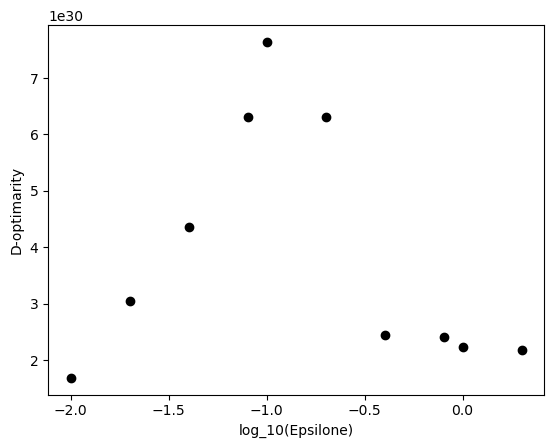

In [5]:
d_values = []
d_best = 0.0
for param in [0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4, 0.8, 1.0, 2.0]:
    x_opt = x_data
    y_opt = y_data
    a_opt = a_data
    np.random.seed(seed=1994)

    # Setting GPR
    kernel = C() * Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=2.5)+ WhiteKernel(noise_level=1.0) +C()*DotProduct()
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20, normalize_y=False, copy_X_train=True, random_state=1994)
    gp.fit(x_opt, y_opt)

    # Generating exploitation points
    iopt=1
    data = {'aq_type':aq_type, 'epsilone':param, 'method':bbo_type}
    gb = gen_batch(nbatch=nbatch, x_data=x_opt, y_data=y_opt, a_data=a_opt, gpr=gp, grid=grids, ibatch=iopt, **data)
    x_next, a_next, y_next = gb.algorithm()
    # Append new conditions
    x_opt = np.append(x_opt, x_next, axis=0)
    y_opt = np.append(y_opt, y_next)
    a_opt = np.append(a_opt, a_next)
    
    # Generating exploration points
    iopt=2
    data = {'aq_type':aq_type, 'epsilone':param*coeficient, 'method':bbo_type}
    gb = gen_batch(nbatch=nbatch, x_data=x_opt, y_data=y_opt, a_data=a_opt, gpr=gp, grid=grids, ibatch=iopt, **data)
    x_next, a_next, y_next = gb.algorithm()
    # Append new conditions
    x_opt = np.append(x_opt, x_next, axis=0)
    y_opt = np.append(y_opt, y_next)
    a_opt = np.append(a_opt, a_next)
    
    # Evaluating the D-optimality
    xt_x = np.dot(x_opt.T, x_opt)
    d_value = np.linalg.det(xt_x)
    d_values.append( [param, d_value] )
    if d_best < d_value:
        d_best = d_value
        best_param = param
    print( param, d_value )

d_values = np.array( d_values )
plt.scatter( np.log10(d_values[:,0]), d_values[:,1], c='black' )
plt.xlabel('log_10(Epsilone)')
plt.ylabel('D-optimarity')
plt.savefig('BO_suggest_%s_mg.png'%(date), format="png")

In [6]:
x_opt = x_data
y_opt = y_data
a_opt = a_data
np.random.seed(seed=1994)

kernel = C() * Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=2.5) + WhiteKernel(noise_level=1.0) +C()*DotProduct()
gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, 
        optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20, 
        normalize_y=False, copy_X_train=True, random_state=1994)
gp.fit(x_opt, y_opt)

iopt=1
data = {'aq_type':aq_type, 'epsilone':best_param, 'method':bbo_type}
gb = gen_batch(nbatch=nbatch, x_data=x_opt, y_data=y_opt, a_data=a_opt, gpr=gp, grid=grids, ibatch=iopt, **data)
x_next, a_next, y_next = gb.algorithm()
x_opt = np.append(x_opt, x_next, axis=0)
y_opt = np.append(y_opt, y_next)
a_opt = np.append(a_opt, a_next)

iopt=2
data = {'aq_type':aq_type, 'epsilone':best_param*coeficient, 'method':bbo_type}
gb = gen_batch(nbatch=nbatch, x_data=x_opt, y_data=y_opt, a_data=a_opt, gpr=gp, grid=grids, ibatch=iopt, **data)
x_next, a_next, y_next = gb.algorithm()
x_opt = np.append(x_opt, x_next, axis=0)
y_opt = np.append(y_opt, y_next)
a_opt = np.append(a_opt, a_next)

## 6. Output suggestions

In [7]:
df = pd.DataFrame(x_opt, columns=title_data)
df['EXP-ID'] = a_opt.astype('int')
df[y_label[0]+'_pred'] = y_opt
df[ndata:].to_csv('BO_suggest_%s.csv'%(date))

df = pd.DataFrame(x_opt*unit2mg, columns=title_data)
df['EXP-ID'] = a_opt.astype('int')
df[y_label[0]+'_pred'] = y_opt
df[ndata:].to_csv('BO_suggest_%s_mg.csv'%(date))